### FACE RECOGNITION USING EIGEN FACES AND SVM
The dataset belongs to a dataset coming directly from sklearn library. It is a preprocessed collection of images of famous people.

We shall apply Principal Component Analysis (PCA) to drill down to the important principal components that explain 95% of variability cumulatively.

After, that we shall create a pipeline with classifier as SVM and use GridSearchCV to find optimal values for hyperparamters.
We shall see model performance on the test sets.

Also, in the end we shall see and understand the intuition of eigen faces.

In [1]:
# imports
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import time

In [2]:
# import the dataset with classes having minimum sample size as 50
lfw_people = fetch_lfw_people(min_faces_per_person = 50)
print("Each row corresponds to a ravelled face image of original size 62 x 47 pixels")
print("The total samples in the dataset are: {}".format(lfw_people.data.shape[0]))
print("Total features are: {}".format(lfw_people.data.shape[1]))

Each row corresponds to a ravelled face image of original size 62 x 47 pixels
The total samples in the dataset are: 1560
Total features are: 2914


In [3]:
print("Total classes, meaning distinct individuals, are: {}".format(len(lfw_people.target_names)))

Total classes, meaning distinct individuals, are: 12


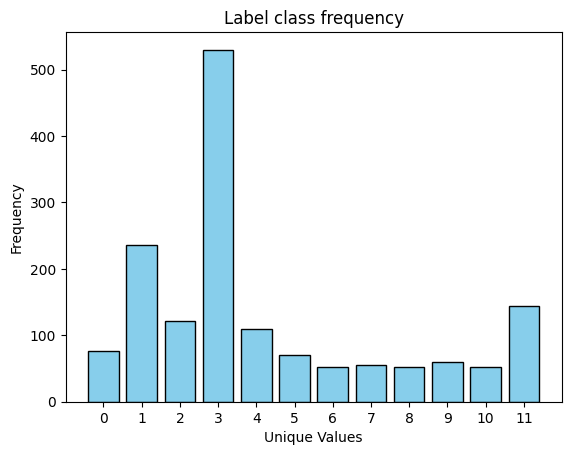

In [4]:
# Imbalanced class case
unique_values, counts = np.unique(lfw_people.target, return_counts=True)
plt.bar(range(len(unique_values)), counts, color='skyblue', edgecolor='black')
plt.xticks(range(len(unique_values)), unique_values)
plt.xlabel("Unique Values")
plt.ylabel("Frequency")
plt.title('Label class frequency')
plt.show()

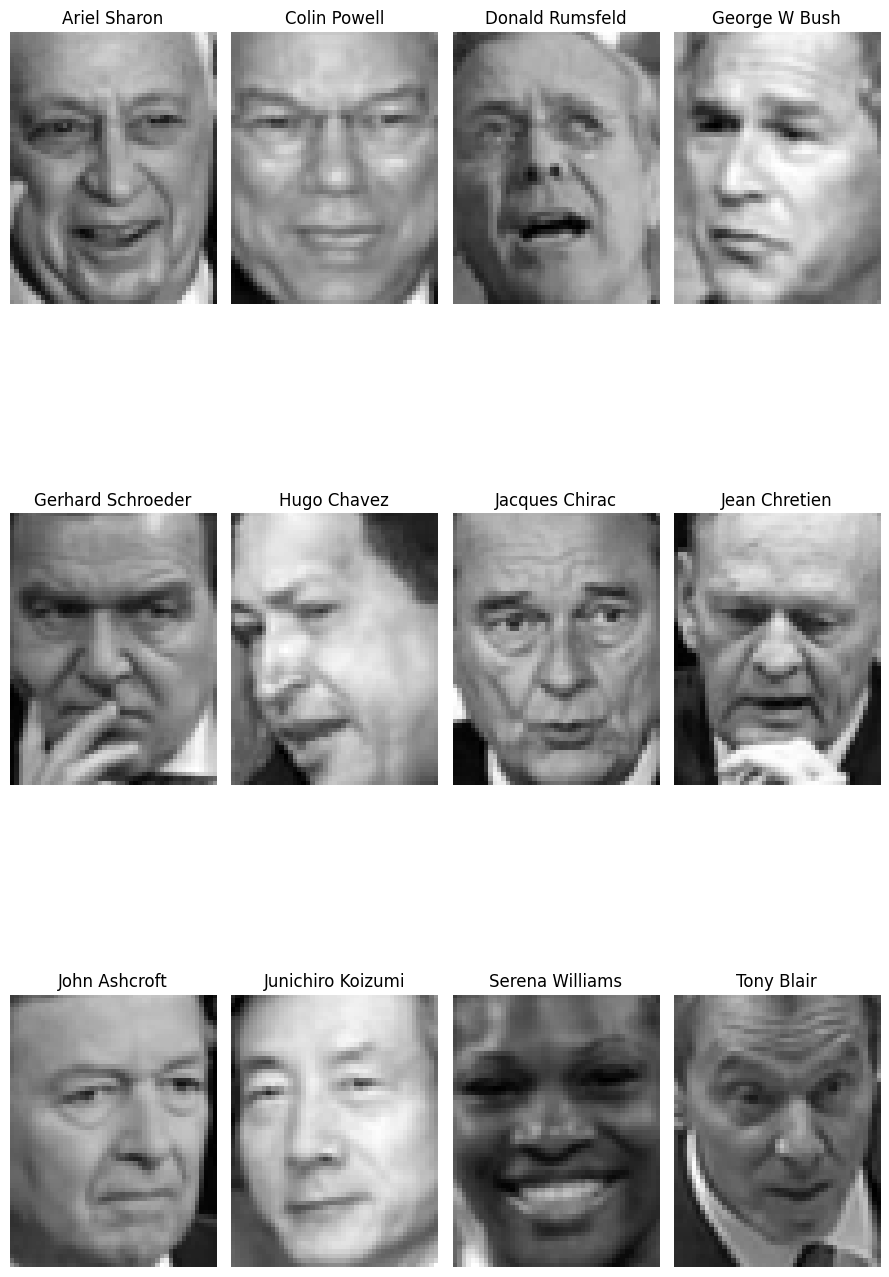

In [6]:
#glimpse of all distinct individuals, total classes
def get_index(arr):
    """
    Get a list of indexes of unique values in a numpy array
    """
    unq_index = []
    for val in np.unique(arr):
        indx = np.where(arr == val)[0][0] 
        unq_index.append((val, indx))
    return unq_index

#list of index containing unique values in numpy array  
indx_list = get_index(arr=lfw_people.target)

def plot_figures(row, cols, row_h=3, col_h=4):
    """
    Plot figure of distinct indivduals, meaning total classes
    """
    fig, axes = plt.subplots(row, cols, figsize=(row*row_h,cols*col_h)) 
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        ax.imshow(lfw_people.images[indx_list[i][1]], cmap='gray')
        ax.set_title(lfw_people.target_names[i])
        ax.axis('off')   
    plt.tight_layout()
    plt.show()

#glimpse of all distinct individuals, total classes
plot_figures(3,4)

In [7]:
# preprare the data matrix
X, y = lfw_people.data, lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify as the classes are imbalanced
print("Train set: {} records.".format(X_train.shape[0]))
print("Test set: {} records.".format(X_test.shape[0]))

Train set: 1092 records.
Test set: 468 records.


In [8]:
# estimate the maximum number of components
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=None)
pca.fit(X_train_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [9]:
# get the explained variance ratio for principal components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

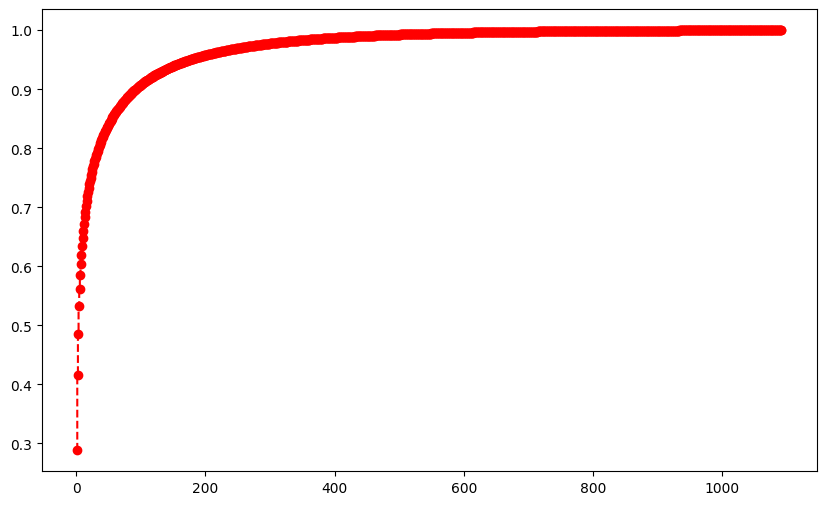

In [10]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance,
         where='mid', label='Cumulative explained variance', linestyle='--', marker='o', color='red')
plt.show()

In [11]:
# let us find the total components that explain 95% of variability
p_comp = np.where(cumulative_explained_variance >= 0.95)[0][0]
print("95% of total variability is explained by first {} principal components.".format(p_comp))

95% of total variability is explained by first 175 principal components.


In [13]:
# create a pipeline for training
t0 = time.perf_counter()
scaler = StandardScaler()
pca = PCA(n_components=p_comp)
classifier = SVC(random_state=42, class_weight="balanced", kernel = 'rbf')

pipeline = Pipeline([
    ('scaler', scaler),         
    ('pca', pca),               
    
    ('classifier', classifier)  
])

param_grid = {
    'classifier__C': [70000, 80000, 90000, 100000, 110000, 120000, 140000],
    'classifier__gamma': [0.000001, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,      
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 # all cpu cores
)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print("Total time taken for grid_search operation is {} seconds.".format(round(time.perf_counter() - t0,1)))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=np.int64(175))),
                ('classifier',
                 SVC(C=100000, class_weight='balanced', gamma=2e-05,
                     random_state=42))])
Total time taken for grid_search operation is 10.8 seconds.


In [14]:
print("Best training accuracy score: {}".format(round(grid_search.best_score_,3)))
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Best testing accuracy score: {}".format(round(test_accuracy,3)))

Best training accuracy score: 0.804
Best testing accuracy score: 0.81


In [15]:
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.70      0.62        23
     Colin Powell       0.83      0.76      0.79        71
  Donald Rumsfeld       0.78      0.81      0.79        36
    George W Bush       0.89      0.91      0.90       159
Gerhard Schroeder       0.76      0.85      0.80        33
      Hugo Chavez       0.87      0.62      0.72        21
   Jacques Chirac       0.75      0.75      0.75        16
    Jean Chretien       0.80      0.75      0.77        16
    John Ashcroft       0.77      0.62      0.69        16
Junichiro Koizumi       1.00      0.72      0.84        18
  Serena Williams       0.93      0.88      0.90        16
       Tony Blair       0.66      0.77      0.71        43

         accuracy                           0.81       468
        macro avg       0.80      0.76      0.77       468
     weighted avg       0.82      0.81      0.81       468



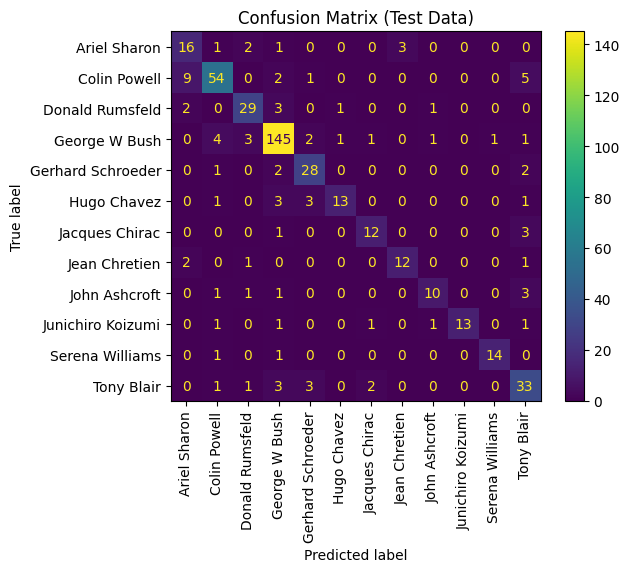

In [16]:
# confusion matrix to get an idea of misclassification
disp=ConfusionMatrixDisplay.from_estimator(best_pipeline, X_test, y_test, display_labels=lfw_people.target_names, xticks_rotation="vertical")
disp.ax_.set_title("Confusion Matrix (Test Data)")
plt.show()

We can interpret from the classification report and the confusion matrix that:
* Ariel Sharon has the lowest precision meaning others are being falsely classified as Ariel.
* Ariel Sharon, Hugo Chavez, John Ashcroft are in low ranges for recall, meaning a few true samples from their respective classes are being falsely classified into other classes.
* Junichiro Koizumi has the highest precision meaning no one else's sample is misclassified as him. Maybe asian facial features might be contributing to such a score.
* Serena Williams also has high precison, recall and f1 scores. Maybe female facial features might be contributing to such a score.

In [17]:
#get the top 10 eigen vectors to plot the eigenfaces
pipeline_2 = Pipeline([
    ('scaler', scaler),         
    ('pca', pca)  
])
pipeline_2.fit(X_train)
pca_step = pipeline_2.named_steps['pca']
principal_components_scaled = pca_step.components_
eigenfaces = pipeline_2.named_steps['scaler'].inverse_transform(principal_components_scaled)

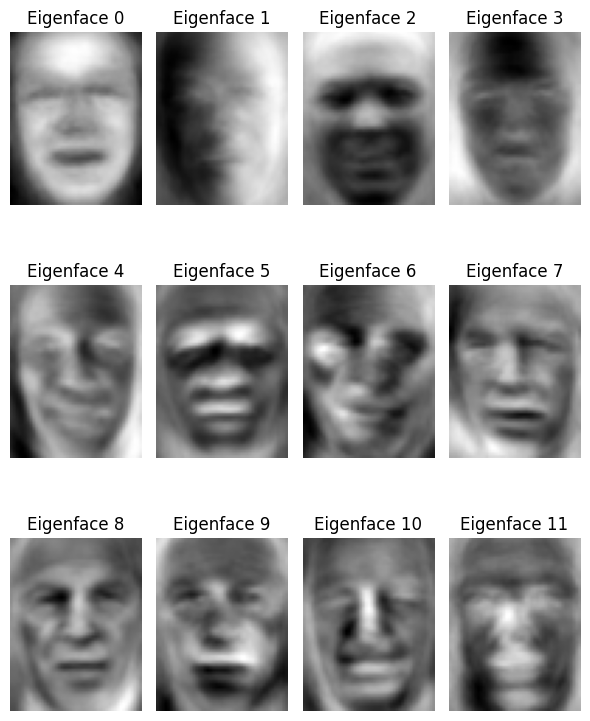

In [18]:
def plot_figures(row, cols, row_h=2, col_h=2):
    """
    Plot figure of distinct indivduals, meaning total classes
    """
    fig, axes = plt.subplots(row, cols, figsize=(row*row_h,cols*col_h)) 
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        ax.imshow(principal_components_scaled[i].reshape(62, 47), cmap='gray')
        ax.set_title('Eigenface {}'.format(i))
        ax.axis('off')   
    plt.tight_layout()
    plt.show()

#glimpse of all distinct individuals, total classes
plot_figures(3,4)

Well, it does not make sense to look at descaled eigenvectors since we underwent scaling in our preprocessing step, hence, we will be looking at eigenvalues of the scaled version of our data.


What we can see are top 12 eigenfaces. Eigenfaces are basically eigenvectors when reshaped back to the original space.


If we look at the eigenface 0, it highlights basic elements of the face where features are important. The basic face, excluding eyes, lips and a bit of nose, is a significant decider. 

When looked at eigenface 2, we can see parts above the hairline becoming a deciding feature.